### Carregar Dados do Yahoo Finance

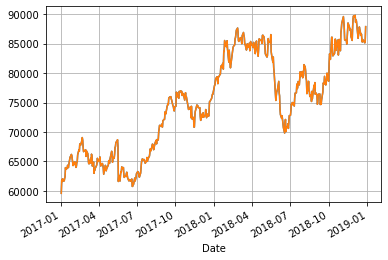

In [390]:
import numpy as np
import pandas as pd
import pandas_datareader as web

import matplotlib.pyplot as plt
import seaborn as sns

TICKERS = ['ITSA4.SA','TAEE11.SA','ODPV3.SA','BBAS3.SA','SANB4.SA','COGN3.SA','^BVSP']

df = web.get_data_yahoo('^BVSP')
df.loc['2017-01-01':'2018-12-31']['Adj Close'].plot()
df.loc['2017-01-01':'2018-12-31']['Close'].plot()
plt.grid()

In [391]:
row = []
return_dict = {}

for ticker in TICKERS:
    df = web.get_data_yahoo(ticker, '2017-01-01', '2019-12-31')
    subdf = df.loc['2017-01-01':'2018-12-31'].copy()
    subdf['Return'] = subdf['Adj Close'].pct_change(1)
    
    #populate dict with returns
    return_dict[ticker] = subdf['Return']
    
    #create table with returns and volatility
    exp_return = np.mean(subdf['Return'])
    volatility = np.sqrt(np.var(subdf['Return']))
    
    row.append([ticker, exp_return, volatility])

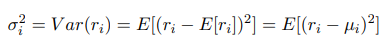

C:\Users\rsasa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Return', ylabel='Density'>

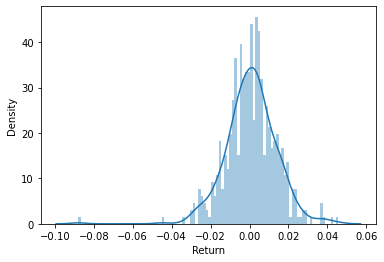

In [392]:
sns.distplot(subdf['Return'].dropna(),bins=100)

In [628]:
final_df = pd.DataFrame(row,columns = ['Ticker','Mean Daily Return','Volatility'])
final_df['Mean Daily Return'] = final_df['Mean Daily Return']

In [750]:
final_df

,Ticker,Mean Daily Return,Volatility
0,ITSA4.SA,0.001380,0.017628
1,TAEE11.SA,0.000723,0.014195
2,ODPV3.SA,0.000505,0.018635
3,BBAS3.SA,0.001513,0.024902
4,SANB4.SA,0.001889,0.022754
5,COGN3.SA,-0.000354,0.025866
6,^BVSP,0.000875,0.013036


#### Calculando correlacao

In [629]:
corr_df = pd.DataFrame.from_dict(return_dict).dropna().corr()
corr_dict = corr_df.to_dict()
corr_df

,ITSA4.SA,TAEE11.SA,ODPV3.SA,BBAS3.SA,SANB4.SA,COGN3.SA,^BVSP
ITSA4.SA,1.000000,0.416296,0.318412,0.745827,0.526815,0.446594,0.848554
TAEE11.SA,0.416296,1.000000,0.203904,0.443104,0.282447,0.266425,0.487750
ODPV3.SA,0.318412,0.203904,1.000000,0.323930,0.198832,0.221205,0.336987
BBAS3.SA,0.745827,0.443104,0.323930,1.000000,0.489544,0.372011,0.817444
SANB4.SA,0.526815,0.282447,0.198832,0.489544,1.000000,0.281121,0.535811
COGN3.SA,0.446594,0.266425,0.221205,0.372011,0.281121,1.000000,0.515574
^BVSP,0.848554,0.487750,0.336987,0.817444,0.535811,0.515574,1.000000


In [630]:
def expected_return(w,rets):
    return (w*rets).sum()

def portfolio_volatility(vlt,w,df_corr):
        
    #Term1
    term1 = np.sum((vlt*w)**2)

    #Term2
    #YOLO: Faz subselecao
    secsum = 0
    for i in range(0,len(w)-1):
        for j in range(1,len(w)):
            if i != j:
                secsum = secsum + w[i]*w[j]*(df_corr.iloc[i,j])*vlt[i]*vlt[j]
    term2 = 2*secsum
    
    vol_port = np.sqrt(term1 + term2)
    
    return vol_port
    

### MSR 

Como estamos desconsiderando a taxa livre de risco, simplificamos nosso problema para rp/sigmap

In [ ]:
maximize MSR 

### GMV

qro descobrir w1,w2,...wn

In [631]:
%%time

import itertools
STEP = 0.01
w1s = np.arange(0,1 + STEP, STEP)

N_STOCKS = 3
vlt = final_df['Volatility'][:N_STOCKS]
rets = final_df['Mean Daily Return'][:N_STOCKS]
df_corr = pd.DataFrame.from_dict(return_dict).dropna().corr()[:N_STOCKS].iloc[:,:N_STOCKS]

info = []    
for w1,w2 in itertools.product(w1s,w1s):
    
    w = np.array([w1,w2,1-w1-w2])
    
    if (1-w1-w2) >= 0.00000000001: 
        exp_ret = expected_return(w,rets)

        vol_port = portfolio_volatility(vlt,w,df_corr)

        info.append([w,exp_ret,vol_port])
    #     print('w1:',w1,'- Exp Return:',exp_ret.sum(),'- Port Volat:',vol_port) 

Wall time: 2.69 s


In [632]:
z = pd.DataFrame(info).rename(columns={1:'Return',2:'Volatility'})
z['Sharpe'] = z['Return']/z['Volatility']

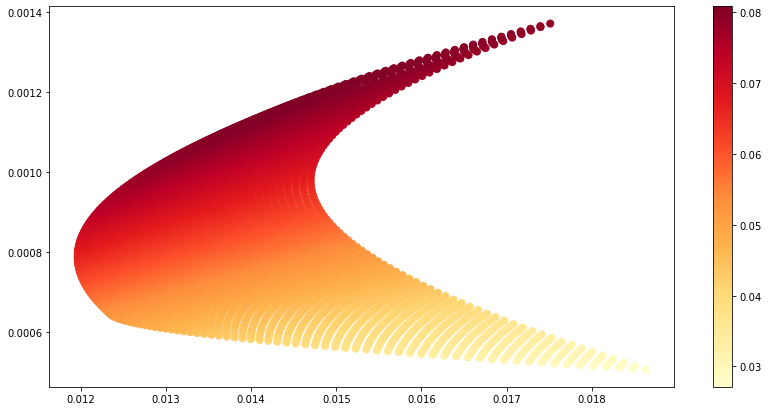

In [633]:
f, ax = plt.subplots(figsize = (14,7))
#cmap=sns.color_palette("RdBu", 10)

cmap = sns.cubehelix_palette(as_cmap=True)
cmap = sns.color_palette("YlOrRd", 10, as_cmap=True)
points = ax.scatter(z['Volatility'],z['Return'],c=z['Sharpe'], s=50, cmap=cmap)
f.colorbar(points)
plt.show()

In [634]:
z.sort_values(by='Volatility',ascending=True)[:100]

,0,Return,Volatility,Sharpe
1783,"[0.19, 0.54, 0.27]",0.000789,0.011964,0.065961
1702,"[0.18, 0.55, 0.27]",0.000783,0.011965,0.065406
1701,"[0.18, 0.54, 0.28]",0.000780,0.011965,0.065223
1782,"[0.19, 0.53, 0.28]",0.000787,0.011965,0.065770
1863,"[0.2, 0.53, 0.27]",0.000796,0.011965,0.066501
...,...,...,...,...
2249,"[0.25, 0.49, 0.26]",0.000831,0.012006,0.069193
1278,"[0.13, 0.56, 0.30999999999999994]",0.000741,0.012006,0.061720
2251,"[0.25, 0.51, 0.24]",0.000835,0.012006,0.069552
1868,"[0.2, 0.58, 0.22000000000000008]",0.000807,0.012007,0.067177


### Algoritmo Genético

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    return np.sum(X)

algorithm_param = {'max_num_iteration': 3000,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

varbound=np.array([[0,1]]*3)

model=ga(function=f,dimension=3,variable_type='real',variable_boundaries=varbound,
        algorithm_parameters=algorithm_param)

In [382]:
MAX=10
PCT_MUTATION = 0.2

value = [30,-10,4,2,-2,1] 
#optimal_solution = [1,0,1,1,0,1]

pop = [[1,1,1,1,1,1],
       [0,0,0,0,0,0],
       [1,0,0,1,0,1],
       [0,1,1,1,0,0]]

### Real Encoding

In [523]:
def normalize(v):
    
    if isinstance(v,list):
        v = np.array(v)
        
    return  v / np.sum(v)

### pt de atenção, as probabilidades são todas quase iguais pq a funcao da um valor mt proximo

In [552]:
print(fs_list)

no = np.array(1 - np.array(fs_list))/np.array(1 - np.array(fs_list)).sum()

[0.01290116363884011, 0.014800161812708183, 0.01283374502252406, 0.012560811801624862]


In [535]:
np.abs(fs_list)/np.abs(fs_list).sum()

array([0.25127756, 0.23085706, 0.27389936, 0.24396602])

In [693]:
MAX=1000
PCT_MUTATION = 0.15
POP_MAX = 5

def random_solution(value):
    return [np.random.uniform() for x in range(len(value))]

N_STOCKS = 7
vlt = np.array(final_df['Volatility'][:N_STOCKS])
rets = np.array(final_df['Mean Daily Return'][:N_STOCKS])
df_corr = pd.DataFrame.from_dict(return_dict).dropna().corr()[:N_STOCKS].iloc[:,:N_STOCKS]

pop = [random_solution(vlt),
      random_solution(vlt),
      random_solution(vlt),
      random_solution(vlt)]

for phase in np.arange(MAX):
    
    #cria new_pop e normaliza dados
    new_pop = pop.copy()
    pop = [normalize(x) for x in pop]
    
    
    #SELECAO ====================
    # Calcular funcao de fitness de cada solução
    fs_list = []
    for solution in pop:
        vol_port = portfolio_volatility(vlt,solution,df_corr)
        fs_list.append(vol_port)  #-1 pois queremos maximizar
        ##print(solution,solution.sum(),vol_port)
        
    # Aleatoriamente escolher 2 soluções baseado no F.S
    print(np.sum(pop))
    idx_list = list(range(len(fs_list)))
    prob_fs = np.array(1 - np.array(fs_list))/np.array(1 - np.array(fs_list)).sum()
    choosen_idx = np.random.choice(idx_list, p = prob_fs)
    par1 = new_pop[choosen_idx]
    #exclui index escolhido da fs e idx_list
    fs_list.pop(choosen_idx)
    new_pop.pop(choosen_idx)

    idx_list = list(range(len(fs_list)))
    prob_fs = np.array(1 - np.array(fs_list))/np.array(1 - np.array(fs_list)).sum()
    choosen_idx = np.random.choice(idx_list, p = prob_fs)
    par2 = new_pop[choosen_idx]

    #exclui index escolhido da fs e idx_list
    fs_list.pop(choosen_idx)
    idx_list.pop(choosen_idx)
    new_pop.pop(choosen_idx)
    
    #CROSSOVER - singlepoint ====================
    #Metade da solução do primeiro + metade da solução do segundo
    #TODO: fazer o single point nao ser obrigatoriamente metade do cromososomo

    #single_point = len(par1)//2
    single_point =np.random.randint(0,len(par1))
    
    new_cromo1 = list(par1[:single_point]) + list(par2[single_point:]) 
    new_cromo1 = normalize(new_cromo1)

    #MUTAÇÃO ====================

    for new_cromo in [new_cromo1]:#,new_cromo2]:
        for idx in range(len(new_cromo)):

            #muda o gene caso PCT_MUTATION
            if np.random.random() < PCT_MUTATION:

                new_cromo[idx] = np.random.uniform()
                new_cromo = normalize(new_cromo)
                
     #==============================
    
    pop.append(new_cromo1)
    
    #pop.append(new_cromo2)
    
#     best_sol = np.max(np.sum(np.array(value)*np.array(pop),axis=1))
    
    eval_pop = []
    for solution in pop:
        eval_pop.append(portfolio_volatility(vlt,np.array(solution),df_corr))    
    best_sol = np.min(eval_pop)
    
    #survival of the fittest
    if len(pop) > POP_MAX:
        #extrai a pior solução de pop
        worst_idx = np.argmax(eval_pop)
        pop.pop(worst_idx)
        eval_pop.pop(worst_idx)
        
    print('Round',phase + 1,':',best_sol, pop[np.argmin(eval_pop)])

4.0
Round 1 : 0.015954076291477704 [0.21708915 0.24109845 0.13234311 0.17172005 0.16455711 0.04662478
 0.02656735]
5.0
Round 2 : 0.015954076291477704 [0.21708915 0.24109845 0.13234311 0.17172005 0.16455711 0.04662478
 0.02656735]
5.0
Round 3 : 0.015954076291477704 [0.21708915 0.24109845 0.13234311 0.17172005 0.16455711 0.04662478
 0.02656735]
5.0
Round 4 : 0.015954076291477704 [0.21708915 0.24109845 0.13234311 0.17172005 0.16455711 0.04662478
 0.02656735]
5.0
Round 5 : 0.015954076291477704 [0.21708915 0.24109845 0.13234311 0.17172005 0.16455711 0.04662478
 0.02656735]
5.0
Round 6 : 0.015954076291477704 [0.21708915 0.24109845 0.13234311 0.17172005 0.16455711 0.04662478
 0.02656735]
5.0
Round 7 : 0.015954076291477704 [0.21708915 0.24109845 0.13234311 0.17172005 0.16455711 0.04662478
 0.02656735]
5.0
Round 8 : 0.015954076291477704 [0.21708915 0.24109845 0.13234311 0.17172005 0.16455711 0.04662478
 0.02656735]
5.0
Round 9 : 0.015954076291477704 [0.21708915 0.24109845 0.13234311 0.17172005 

Round 89 : 0.013062190384912084 [0.26097365 0.34531817 0.18040947 0.00570969 0.06069002 0.0729275
 0.07397149]
5.0
Round 90 : 0.013062190384912084 [0.26097365 0.34531817 0.18040947 0.00570969 0.06069002 0.0729275
 0.07397149]
5.0
Round 91 : 0.013062190384912084 [0.26097365 0.34531817 0.18040947 0.00570969 0.06069002 0.0729275
 0.07397149]
5.0
Round 92 : 0.013062190384912084 [0.26097365 0.34531817 0.18040947 0.00570969 0.06069002 0.0729275
 0.07397149]
5.0
Round 93 : 0.013062190384912084 [0.26097365 0.34531817 0.18040947 0.00570969 0.06069002 0.0729275
 0.07397149]
5.0
Round 94 : 0.013062190384912084 [0.26097365 0.34531817 0.18040947 0.00570969 0.06069002 0.0729275
 0.07397149]
5.0
Round 95 : 0.013062190384912084 [0.26097365 0.34531817 0.18040947 0.00570969 0.06069002 0.0729275
 0.07397149]
5.0
Round 96 : 0.013062190384912084 [0.26097365 0.34531817 0.18040947 0.00570969 0.06069002 0.0729275
 0.07397149]
5.0
Round 97 : 0.013062190384912084 [0.26097365 0.34531817 0.18040947 0.00570969 0.0

5.000000000000001
Round 173 : 0.012894334070091204 [0.27660444 0.36600071 0.19026257 0.00607004 0.01775632 0.07114374
 0.07216219]
5.000000000000001
Round 174 : 0.012894334070091204 [0.27660444 0.36600071 0.19026257 0.00607004 0.01775632 0.07114374
 0.07216219]
5.0
Round 175 : 0.012894334070091204 [0.27660444 0.36600071 0.19026257 0.00607004 0.01775632 0.07114374
 0.07216219]
4.999999999999999
Round 176 : 0.012894334070091204 [0.27660444 0.36600071 0.19026257 0.00607004 0.01775632 0.07114374
 0.07216219]
4.999999999999999
Round 177 : 0.012894334070091204 [0.27660444 0.36600071 0.19026257 0.00607004 0.01775632 0.07114374
 0.07216219]
5.0
Round 178 : 0.012894334070091204 [0.27660444 0.36600071 0.19026257 0.00607004 0.01775632 0.07114374
 0.07216219]
4.999999999999999
Round 179 : 0.012894334070091204 [0.27660444 0.36600071 0.19026257 0.00607004 0.01775632 0.07114374
 0.07216219]
5.0
Round 180 : 0.01288920841975894 [0.27212613 0.36814296 0.19137621 0.00610556 0.01788717 0.071668
 0.0726939

Round 245 : 0.012861203727886168 [0.27913855 0.37762964 0.18087077 0.0057704  0.01690527 0.0676284
 0.07205696]
5.0
Round 246 : 0.012861203727886168 [0.27913855 0.37762964 0.18087077 0.0057704  0.01690527 0.0676284
 0.07205696]
5.0
Round 247 : 0.012861203727886168 [0.27913855 0.37762964 0.18087077 0.0057704  0.01690527 0.0676284
 0.07205696]
5.0
Round 248 : 0.012861203727886168 [0.27913855 0.37762964 0.18087077 0.0057704  0.01690527 0.0676284
 0.07205696]
4.999999999999999
Round 249 : 0.012861203727886168 [0.27913855 0.37762964 0.18087077 0.0057704  0.01690527 0.0676284
 0.07205696]
5.0
Round 250 : 0.012861203727886168 [0.27913855 0.37762964 0.18087077 0.0057704  0.01690527 0.0676284
 0.07205696]
4.999999999999999
Round 251 : 0.012861203727886168 [0.27913855 0.37762964 0.18087077 0.0057704  0.01690527 0.0676284
 0.07205696]
4.999999999999999
Round 252 : 0.012861203727886168 [0.27913855 0.37762964 0.18087077 0.0057704  0.01690527 0.0676284
 0.07205696]
4.999999999999999
Round 253 : 0.01

Round 323 : 0.012744494155499178 [0.18390566 0.44217223 0.20448089 0.00652365 0.01671101 0.06685129
 0.07935528]
5.000000000000001
Round 324 : 0.012744494155499178 [0.18390566 0.44217223 0.20448089 0.00652365 0.01671101 0.06685129
 0.07935528]
5.000000000000001
Round 325 : 0.012744494155499178 [0.18390566 0.44217223 0.20448089 0.00652365 0.01671101 0.06685129
 0.07935528]
5.000000000000001
Round 326 : 0.012744494155499178 [0.18390566 0.44217223 0.20448089 0.00652365 0.01671101 0.06685129
 0.07935528]
5.000000000000001
Round 327 : 0.012744494155499178 [0.18390566 0.44217223 0.20448089 0.00652365 0.01671101 0.06685129
 0.07935528]
5.0
Round 328 : 0.012744494155499178 [0.18390566 0.44217223 0.20448089 0.00652365 0.01671101 0.06685129
 0.07935528]
5.0
Round 329 : 0.012744494155499178 [0.18390566 0.44217223 0.20448089 0.00652365 0.01671101 0.06685129
 0.07935528]
5.0
Round 330 : 0.012744494155499178 [0.18390566 0.44217223 0.20448089 0.00652365 0.01671101 0.06685129
 0.07935528]
5.0
Round 33

Round 412 : 0.012672205562129205 [0.17920232 0.4372528  0.19746375 0.00628161 0.01607956 0.06501157
 0.09870838]
5.0
Round 413 : 0.012672205562129205 [0.17920232 0.4372528  0.19746375 0.00628161 0.01607956 0.06501157
 0.09870838]
5.0
Round 414 : 0.012672205562129205 [0.17920232 0.4372528  0.19746375 0.00628161 0.01607956 0.06501157
 0.09870838]
5.000000000000001
Round 415 : 0.012672205562129205 [0.17920232 0.4372528  0.19746375 0.00628161 0.01607956 0.06501157
 0.09870838]
5.000000000000001
Round 416 : 0.012672205562129205 [0.17920232 0.4372528  0.19746375 0.00628161 0.01607956 0.06501157
 0.09870838]
5.000000000000001
Round 417 : 0.012672205562129205 [0.17920232 0.4372528  0.19746375 0.00628161 0.01607956 0.06501157
 0.09870838]
5.000000000000001
Round 418 : 0.012672205562129205 [0.17920232 0.4372528  0.19746375 0.00628161 0.01607956 0.06501157
 0.09870838]
5.000000000000001
Round 419 : 0.012672205562129205 [0.17920232 0.4372528  0.19746375 0.00628161 0.01607956 0.06501157
 0.09870838

Round 487 : 0.012670033579806962 [0.17951382 0.43737707 0.19751988 0.00630157 0.01613065 0.0645296
 0.09862741]
5.0
Round 488 : 0.012670033579806962 [0.17951382 0.43737707 0.19751988 0.00630157 0.01613065 0.0645296
 0.09862741]
5.0
Round 489 : 0.012670033579806962 [0.17951382 0.43737707 0.19751988 0.00630157 0.01613065 0.0645296
 0.09862741]
5.0
Round 490 : 0.012670033579806962 [0.17951382 0.43737707 0.19751988 0.00630157 0.01613065 0.0645296
 0.09862741]
5.0
Round 491 : 0.012670033579806962 [0.17951382 0.43737707 0.19751988 0.00630157 0.01613065 0.0645296
 0.09862741]
5.0
Round 492 : 0.012670033579806962 [0.17951382 0.43737707 0.19751988 0.00630157 0.01613065 0.0645296
 0.09862741]
5.0
Round 493 : 0.012670033579806962 [0.17951382 0.43737707 0.19751988 0.00630157 0.01613065 0.0645296
 0.09862741]
5.0
Round 494 : 0.012670033579806962 [0.17951382 0.43737707 0.19751988 0.00630157 0.01613065 0.0645296
 0.09862741]
5.0
Round 495 : 0.012670033579806962 [0.17951382 0.43737707 0.19751988 0.006

Round 557 : 0.012644125104647484 [0.17799079 0.43366628 0.19584408 0.00624811 0.01597161 0.06389335
 0.10638579]
5.0
Round 558 : 0.012644125104647484 [0.17799079 0.43366628 0.19584408 0.00624811 0.01597161 0.06389335
 0.10638579]
5.0
Round 559 : 0.012644125104647484 [0.17799079 0.43366628 0.19584408 0.00624811 0.01597161 0.06389335
 0.10638579]
5.0
Round 560 : 0.012644125104647484 [0.17799079 0.43366628 0.19584408 0.00624811 0.01597161 0.06389335
 0.10638579]
5.0
Round 561 : 0.0122524270005182 [0.17793028 0.40116063 0.1957775  0.00624598 0.01599533 0.06398825
 0.10654381]
5.0
Round 562 : 0.012644125104647484 [0.17799079 0.43366628 0.19584408 0.00624811 0.01597161 0.06389335
 0.10638579]
5.0
Round 563 : 0.012644125104647484 [0.17799079 0.43366628 0.19584408 0.00624811 0.01597161 0.06389335
 0.10638579]
5.0
Round 564 : 0.012644125104647484 [0.17799079 0.43366628 0.19584408 0.00624811 0.01597161 0.06389335
 0.10638579]
5.0
Round 565 : 0.012644125104647484 [0.17799079 0.43366628 0.19584408

Round 628 : 0.012643915937003097 [0.17796256 0.4335975  0.19581302 0.00624711 0.01599543 0.06389376
 0.10649061]
5.0
Round 629 : 0.012236747147026925 [0.17795726 0.39995716 0.19580719 0.00624693 0.0159968  0.06390233
 0.1065049 ]
4.999999999999999
Round 630 : 0.012643915937003097 [0.17796256 0.4335975  0.19581302 0.00624711 0.01599543 0.06389376
 0.10649061]
4.999999999999999
Round 631 : 0.012444111502131016 [0.16206442 0.43359096 0.19581007 0.00624665 0.01599652 0.06389809
 0.10649783]
5.0
Round 632 : 0.012643915937003097 [0.17796256 0.4335975  0.19581302 0.00624711 0.01599543 0.06389376
 0.10649061]
5.0
Round 633 : 0.012643915937003097 [0.17796256 0.4335975  0.19581302 0.00624711 0.01599543 0.06389376
 0.10649061]
5.0
Round 634 : 0.012643915937003097 [0.17796256 0.4335975  0.19581302 0.00624711 0.01599543 0.06389376
 0.10649061]
5.0
Round 635 : 0.012643915937003097 [0.17796256 0.4335975  0.19581302 0.00624711 0.01599543 0.06389376
 0.10649061]
5.0
Round 636 : 0.012643915937003097 [0.

Round 706 : 0.012643912117060936 [0.17795918 0.4335986  0.19581352 0.00624713 0.01599547 0.06389392
 0.10649217]
5.0
Round 707 : 0.012643912117060936 [0.17795918 0.4335986  0.19581352 0.00624713 0.01599547 0.06389392
 0.10649217]
5.0
Round 708 : 0.012643912117060936 [0.17795918 0.4335986  0.19581352 0.00624713 0.01599547 0.06389392
 0.10649217]
5.0
Round 709 : 0.012192109776767358 [0.17795905 0.43359902 0.19581226 0.00624688 0.01599569 0.038848
 0.10649232]
5.0
Round 710 : 0.012505328021859797 [0.18253086 0.44473828 0.20084272 0.00640737 0.01640662 0.03984601
 0.10922813]
5.0
Round 711 : 0.010064563792807185 [0.17795905 0.21106252 0.19581226 0.00624688 0.01599569 0.06389478
 0.10649232]
5.0
Round 712 : 0.012505328021859797 [0.18253086 0.44473828 0.20084272 0.00640737 0.01640662 0.03984601
 0.10922813]
5.0
Round 713 : 0.012505328021859798 [0.18253086 0.44473828 0.20084272 0.00640737 0.01640662 0.03984601
 0.10922813]
5.0
Round 714 : 0.012505328021859797 [0.18253086 0.44473828 0.20084272

Round 796 : 0.012501829860037674 [0.18066496 0.44340307 0.20023974 0.00638813 0.01635736 0.04081478
 0.11213196]
5.0
Round 797 : 0.012501829860037674 [0.18066496 0.44340307 0.20023974 0.00638813 0.01635736 0.04081478
 0.11213196]
5.0
Round 798 : 0.012501829860037674 [0.18066496 0.44340307 0.20023974 0.00638813 0.01635736 0.04081478
 0.11213196]
5.0
Round 799 : 0.012501829860037674 [0.18066496 0.44340307 0.20023974 0.00638813 0.01635736 0.04081478
 0.11213196]
5.0
Round 800 : 0.012501829860037674 [0.18066496 0.44340307 0.20023974 0.00638813 0.01635736 0.04081478
 0.11213196]
5.0
Round 801 : 0.012501829860037674 [0.18066496 0.44340307 0.20023974 0.00638813 0.01635736 0.04081478
 0.11213196]
5.0
Round 802 : 0.012501829860037674 [0.18066496 0.44340307 0.20023974 0.00638813 0.01635736 0.04081478
 0.11213196]
5.0
Round 803 : 0.012501829860037674 [0.18066496 0.44340307 0.20023974 0.00638813 0.01635736 0.04081478
 0.11213196]
5.0
Round 804 : 0.012501829860037674 [0.18066496 0.44340307 0.200239

Round 869 : 0.012499226425021217 [0.1625074  0.45495528 0.20545669 0.00640271 0.01684387 0.04090794
 0.11292611]
4.999999999999999
Round 870 : 0.012499226425021217 [0.1625074  0.45495528 0.20545669 0.00640271 0.01684387 0.04090794
 0.11292611]
4.999999999999999
Round 871 : 0.012499226425021217 [0.1625074  0.45495528 0.20545669 0.00640271 0.01684387 0.04090794
 0.11292611]
5.0
Round 872 : 0.012499226425021217 [0.1625074  0.45495528 0.20545669 0.00640271 0.01684387 0.04090794
 0.11292611]
5.0
Round 873 : 0.012499226425021217 [0.1625074  0.45495528 0.20545669 0.00640271 0.01684387 0.04090794
 0.11292611]
5.0
Round 874 : 0.012499226425021217 [0.1625074  0.45495528 0.20545669 0.00640271 0.01684387 0.04090794
 0.11292611]
5.0
Round 875 : 0.012499226425021217 [0.1625074  0.45495528 0.20545669 0.00640271 0.01684387 0.04090794
 0.11292611]
5.0
Round 876 : 0.012499226425021217 [0.1625074  0.45495528 0.20545669 0.00640271 0.01684387 0.04090794
 0.11292611]
5.0
Round 877 : 0.012499226425021217 [0.

Round 944 : 0.012496899475847215 [0.16237595 0.45458725 0.20529049 0.00639753 0.01683024 0.04087485
 0.11364369]
5.0
Round 945 : 0.012496899475847215 [0.16237595 0.45458725 0.20529049 0.00639753 0.01683024 0.04087485
 0.11364369]
5.0
Round 946 : 0.012496899475847215 [0.16237595 0.45458725 0.20529049 0.00639753 0.01683024 0.04087485
 0.11364369]
5.0
Round 947 : 0.012496899475847215 [0.16237595 0.45458725 0.20529049 0.00639753 0.01683024 0.04087485
 0.11364369]
4.999999999999999
Round 948 : 0.012496899475847215 [0.16237595 0.45458725 0.20529049 0.00639753 0.01683024 0.04087485
 0.11364369]
4.999999999999999
Round 949 : 0.012496899475847215 [0.16237595 0.45458725 0.20529049 0.00639753 0.01683024 0.04087485
 0.11364369]
4.999999999999999
Round 950 : 0.012496899475847215 [0.16237595 0.45458725 0.20529049 0.00639753 0.01683024 0.04087485
 0.11364369]
4.999999999999999
Round 951 : 0.012496899475847215 [0.16237595 0.45458725 0.20529049 0.00639753 0.01683024 0.04087485
 0.11364369]
4.9999999999

In [710]:
subdf

,High,Low,Open,Close,Volume,Adj Close,Return
Date,,,,,,,
2017-01-02,60227.0,59371.0,60227.0,59589.0,808700.0,59589.0,NaN
2017-01-03,61815.0,59631.0,59631.0,61814.0,3328300.0,61814.0,0.037339
2017-01-04,61940.0,61302.0,61811.0,61589.0,2840800.0,61589.0,-0.003640
2017-01-05,62409.0,61594.0,61594.0,62071.0,3313000.0,62071.0,0.007826
2017-01-06,62072.0,61396.0,62072.0,61665.0,2374800.0,61665.0,-0.006541
...,...,...,...,...,...,...,...
2018-12-20,86584.0,84756.0,85678.0,85269.0,6100500.0,85269.0,-0.004727
2018-12-21,86554.0,85134.0,85269.0,85697.0,6076200.0,85697.0,0.005019
2018-12-26,85684.0,83892.0,85684.0,85136.0,3355100.0,85136.0,-0.006546


In [711]:
MY_MONEY = 100_000
optimal_allocation = pop[np.argmin(eval_pop)]
allocated_money = MY_MONEY*optimal_allocation

portfolio_dict = {}
for i,ticker in enumerate(TICKERS):
    df = web.get_data_yahoo(ticker, '2017-01-01', '2019-12-31')
    test_df = df.loc['2019-01-01':'2020-01-01'].copy()
    
    initial_price = test_df.iloc[0]['Adj Close']
    shares_obtained = allocated_money[i]/initial_price
    
    portfolio_dict[ticker] = shares_obtained*test_df['Adj Close']

In [714]:
portfolio = pd.DataFrame.from_dict(portfolio_dict)
portfolio['TOTAL'] = np.sum(portfolio,axis=1)

In [740]:
portfolio

,ITSA4.SA,TAEE11.SA,ODPV3.SA,BBAS3.SA,SANB4.SA,COGN3.SA,^BVSP,TOTAL
Date,,,,,,,,
2019-01-02,15997.550312,44828.027274,20244.227564,630.877290,1658.129464,4029.528352,12611.659745,100000.000000
2019-01-03,16136.661710,44957.650793,20533.429627,633.473554,1690.925894,4077.446431,12688.151155,100717.739164
2019-01-04,16086.077978,46735.212172,20822.631690,633.473554,1738.976600,4081.802735,12726.535431,102824.710160
2019-01-07,16073.425909,45957.525390,20562.347370,629.319577,1766.434363,3977.253128,12706.858293,101673.164030
2019-01-08,16288.412904,45920.493333,19781.502107,622.180135,1728.224337,4007.745993,12753.002567,101101.561377
...,...,...,...,...,...,...,...,...
2019-12-20,18743.120129,60108.991636,24950.853121,706.113801,1611.528972,4800.212406,15952.477492,126873.297556
2019-12-23,18878.449132,60426.292841,25394.297003,727.410541,1625.138223,4936.857331,16055.297466,128043.742537
2019-12-26,19203.236013,61318.711537,25556.892528,735.708126,1649.956033,5113.173919,16240.983135,129818.661292


In [730]:
def one_stock(ticker,money, start_date = '2019-01-01',end_date = '2020-01-01'):
    
    stock_df = web.get_data_yahoo(ticker, start_date, end_date)
    
    initial_price = stock_df.iloc[0]['Adj Close']
    return (money/initial_price)*stock_df['Adj Close']

In [738]:
bov_df = one_stock('^BVSP',100_000, start_date = '2019-01-01',end_date = '2020-01-01')
cog_df = one_stock('COGN3.SA',100_000, start_date = '2019-01-01',end_date = '2020-01-01')
std_df = one_stock('SANB3.SA',100_000, start_date = '2019-01-01',end_date = '2020-01-01')

In [749]:
portfolio

,ITSA4.SA,TAEE11.SA,ODPV3.SA,BBAS3.SA,SANB4.SA,COGN3.SA,^BVSP,TOTAL
Date,,,,,,,,
2019-01-02,15997.550312,44828.027274,20244.227564,630.877290,1658.129464,4029.528352,12611.659745,100000.000000
2019-01-03,16136.661710,44957.650793,20533.429627,633.473554,1690.925894,4077.446431,12688.151155,100717.739164
2019-01-04,16086.077978,46735.212172,20822.631690,633.473554,1738.976600,4081.802735,12726.535431,102824.710160
2019-01-07,16073.425909,45957.525390,20562.347370,629.319577,1766.434363,3977.253128,12706.858293,101673.164030
2019-01-08,16288.412904,45920.493333,19781.502107,622.180135,1728.224337,4007.745993,12753.002567,101101.561377
...,...,...,...,...,...,...,...,...
2020-12-22,16027.584488,72713.772974,21082.811320,550.857677,1991.146875,1983.558783,16122.504593,130472.236708
2020-12-23,16407.183365,72691.718548,21899.614779,559.921128,2034.059448,2027.637825,16331.608827,131951.743918
2020-12-28,16589.954558,74191.885867,23117.117500,566.107311,2061.523440,2027.637825,16497.063072,135051.289572


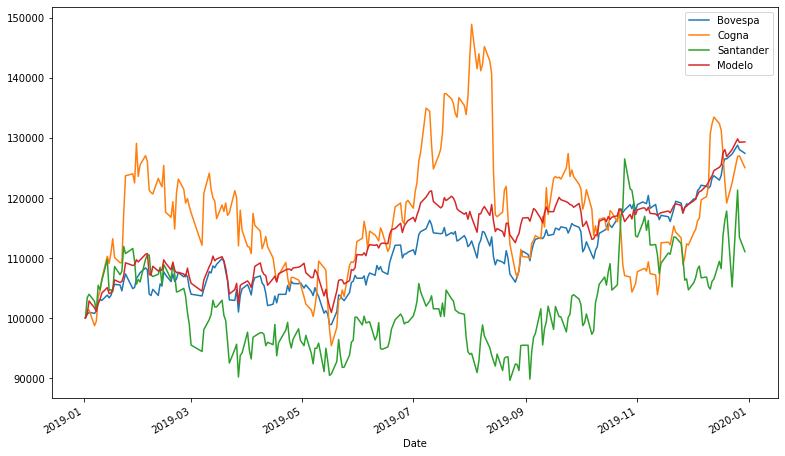

In [739]:
plt.figure(figsize=(13,8))
bov_df.plot(label = 'Bovespa')
cog_df.plot(label = 'Cogna')
std_df.plot(label = 'Santander')
portfolio['TOTAL'].plot(label = 'Modelo')
plt.legend()

Visualmente percebe-se que é possível atingir uma volatilidade similar ao índice Bovespa. Um índice baseando-se no preço de mais de 100 ativos(?).

### Testando 2 anos para frente

In [745]:
MY_MONEY = 100_000
optimal_allocation = pop[np.argmin(eval_pop)]
allocated_money = MY_MONEY*optimal_allocation

portfolio_dict = {}
for i,ticker in enumerate(TICKERS):
    df = web.get_data_yahoo(ticker, '2017-01-01', '2021-12-31')
    test_df = df.loc['2019-01-01':'2021-01-01'].copy()
    
    initial_price = test_df.iloc[0]['Adj Close']
    shares_obtained = allocated_money[i]/initial_price
    
    portfolio_dict[ticker] = shares_obtained*test_df['Adj Close']
    
portfolio = pd.DataFrame.from_dict(portfolio_dict)
portfolio['TOTAL'] = np.sum(portfolio,axis=1)

bov_df = one_stock('^BVSP',100_000, start_date = '2019-01-01',end_date = '2021-01-01')
cog_df = one_stock('COGN3.SA',100_000, start_date = '2019-01-01',end_date = '2021-01-01')
std_df = one_stock('SANB3.SA',100_000, start_date = '2019-01-01',end_date = '2021-01-01')

In [751]:
import os
os.()

['.ipynb_checkpoints', 'Genethic Algo.ipynb', 'Untitled.ipynb']

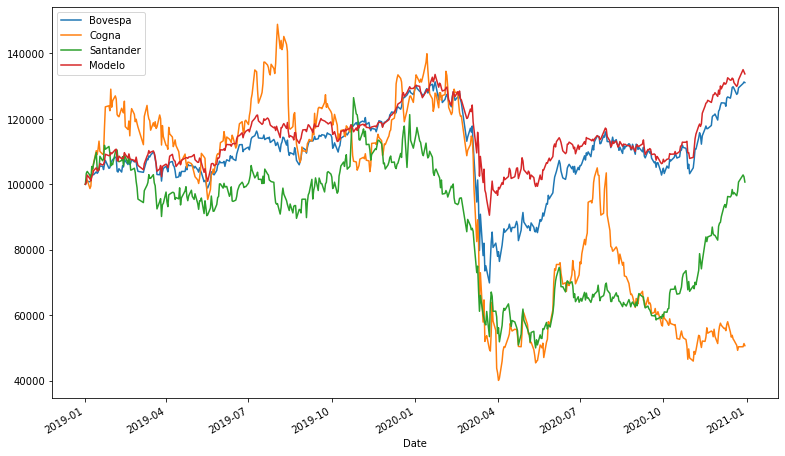

In [746]:
plt.figure(figsize=(13,8))
bov_df.plot(label = 'Bovespa')
cog_df.plot(label = 'Cogna')
std_df.plot(label = 'Santander')
portfolio['TOTAL'].plot(label = 'Modelo')
plt.legend()